This assignment represents my own work. I did not work on this assignment with others. All coding was done by myself.

I understand that if I struggle with this assignment that I will reevaluate whether this is the correct class for me to take. I understand that the homework only gets harder.

# CS 671: Homework 2
### Alex Kumar

### Question 6

In [27]:
### Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [28]:
### 6.1 Read and split data
df = pd.read_csv("Titanic.csv")
df = df.dropna(axis=1)
df["Sex"].replace(["female", "male"], [1, 0], inplace=True)

x, y = df[["Pclass", "Sex", "SibSp", "Parch", "Fare"]], df[["Survived"]]
y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)


In [29]:
### 6.2 Train and fit
# Random forest
forest = RandomForestClassifier()
start = time.time()
forest.fit(x_train, y_train)
stop = time.time()
print("Time to train Random Forest: ", str(stop-start))

# Boosted trees
trees = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1))
start = time.time()
trees.fit(x_train, y_train)
stop = time.time()
print("Time to train Boosted Decision Trees: ", str(stop-start))


Time to train Random Forest:  0.07824397087097168
Time to train Boosted Decision Trees:  0.032958030700683594


In [30]:
### 6.3 Grid Search and ROC/AUC
parameters = {"n_estimators": [10, 50, 100, 300], "max_depth": [1, 2, 3], "criterion": ["gini", "entropy"]}

forest_scores = {}
trees_scores = {}
kf = KFold(n_splits=5)
for n in parameters["n_estimators"]:
    for d in parameters["max_depth"]:
        for c in parameters["criterion"]:
            for train_i, valid_i in kf.split(x, y):
                x_train_temp, x_valid = x.iloc[train_i], x.iloc[valid_i]
                y_train_temp, y_valid = y[train_i], y[valid_i]
                
                forest = RandomForestClassifier(n_estimators=n, max_depth=d, criterion=c)
                trees = AdaBoostClassifier(n_estimators=n, base_estimator=DecisionTreeClassifier(max_depth=d, criterion=c))
                
                forest.fit(x_train_temp, y_train_temp)
                trees.fit(x_train_temp, y_train_temp)
                
                forest_score = forest.score(x_valid, y_valid)
                trees_score = trees.score(x_valid, y_valid)
                
                forest_scores[forest_score] = [n, d, c]
                trees_scores[trees_score] = [n, d, c]        
                

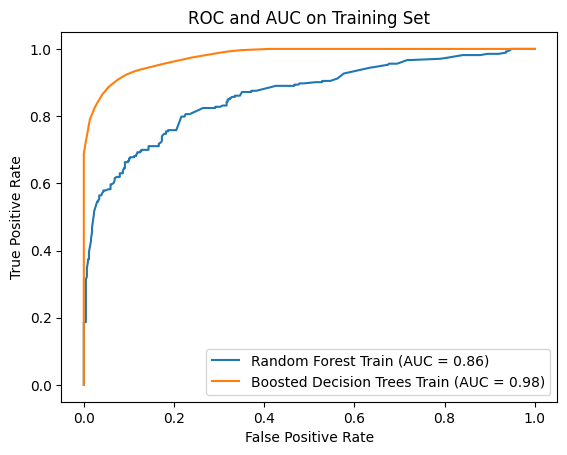

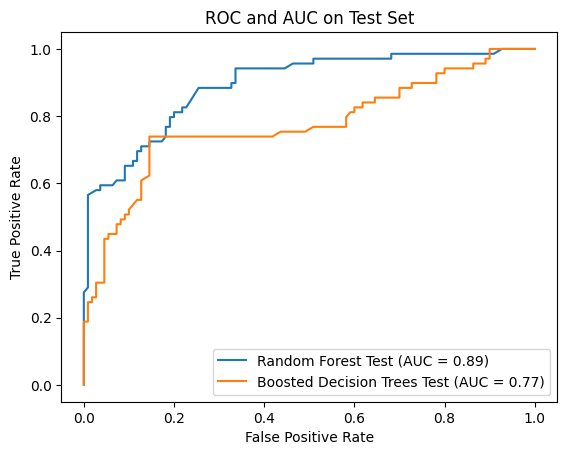

In [31]:
def roc_maker(y, pred, name, idx):
    fpr, tpr, thresholds = metrics.roc_curve(y, pred)
    roc_auc = metrics.auc(fpr, tpr) 
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    display.plot(ax=idx)
    

best_forest_p = forest_scores[max(forest_scores.keys())]
best_trees_p = trees_scores[max(trees_scores.keys())]

opt_forest = RandomForestClassifier(n_estimators=best_forest_p[0], 
                                    max_depth=best_forest_p[1], criterion=best_forest_p[2])
opt_trees = AdaBoostClassifier(n_estimators=best_trees_p[0], 
                               base_estimator=DecisionTreeClassifier(max_depth=best_trees_p[1], 
                                                                     criterion=best_trees_p[2]))

forest.fit(x_train, y_train)
trees.fit(x_train, y_train)

forest_train_pred = forest.predict_proba(x_train)[:, 1]
trees_train_pred = trees.predict_proba(x_train)[:, 1]
plt.figure(1)
ax = plt.axes()
roc_maker(y_train, forest_train_pred, "Random Forest Train", ax)
roc_maker(y_train, trees_train_pred, "Boosted Decision Trees Train", ax)
plt.title("ROC and AUC on Training Set")
plt.show()

forest_test_pred = forest.predict_proba(x_test)[:, 1]
trees_test_pred = trees.predict_proba(x_test)[:, 1]
plt.figure(2)
ax = plt.axes()
roc_maker(y_test, forest_test_pred, "Random Forest Test", ax)
roc_maker(y_test, trees_test_pred, "Boosted Decision Trees Test", ax)
plt.title("ROC and AUC on Test Set")
plt.show()